In [31]:
import numpy as np
import os
import glob
import pandas as pd
import matplotlib.pyplot as plt
from scipy import integrate
import copy


All data needs to be in the same folder

Splitting DataFrames by Model: The code first splits each DataFrame into multiple DataFrames based on the unique values in the 'Model' column. Each split DataFrame contains only the rows corresponding to a specific model.

Normalizing DataFrames: The code then normalizes the numeric columns in each DataFrame. 

Calculating Percentage Differences: The code calculates the percentage difference between the best and second-best values for 'MeanBestFid' and 'AUFSC' columns in each DataFrame.

Color Coding and Formatting: The code applies color coding to the 'Delta_BestFid' and 'Delta_AUFSC' columns based on their values. It also applies bold formatting to the maximum values in the 'Old_BestFid', 'New_BestFid', 'Old_AUFSC', and 'New_AUFSC' columns.

Renaming Columns: The code renames certain columns in each DataFrame according to a predefined mapping.

Reordering Columns: The code reorders the columns in each DataFrame to a specific order.

Generating LaTeX Tables: Finally, the code converts each DataFrame into a LaTeX table and saves it to a .tex file.

C:\Users\jesse\AppData\Local\Temp\ipykernel_1416\2462510989.py:68: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  mean_best_fid_table = pd.concat([mean_best_fid_table, pd.DataFrame([new_row])], ignore_index=True)


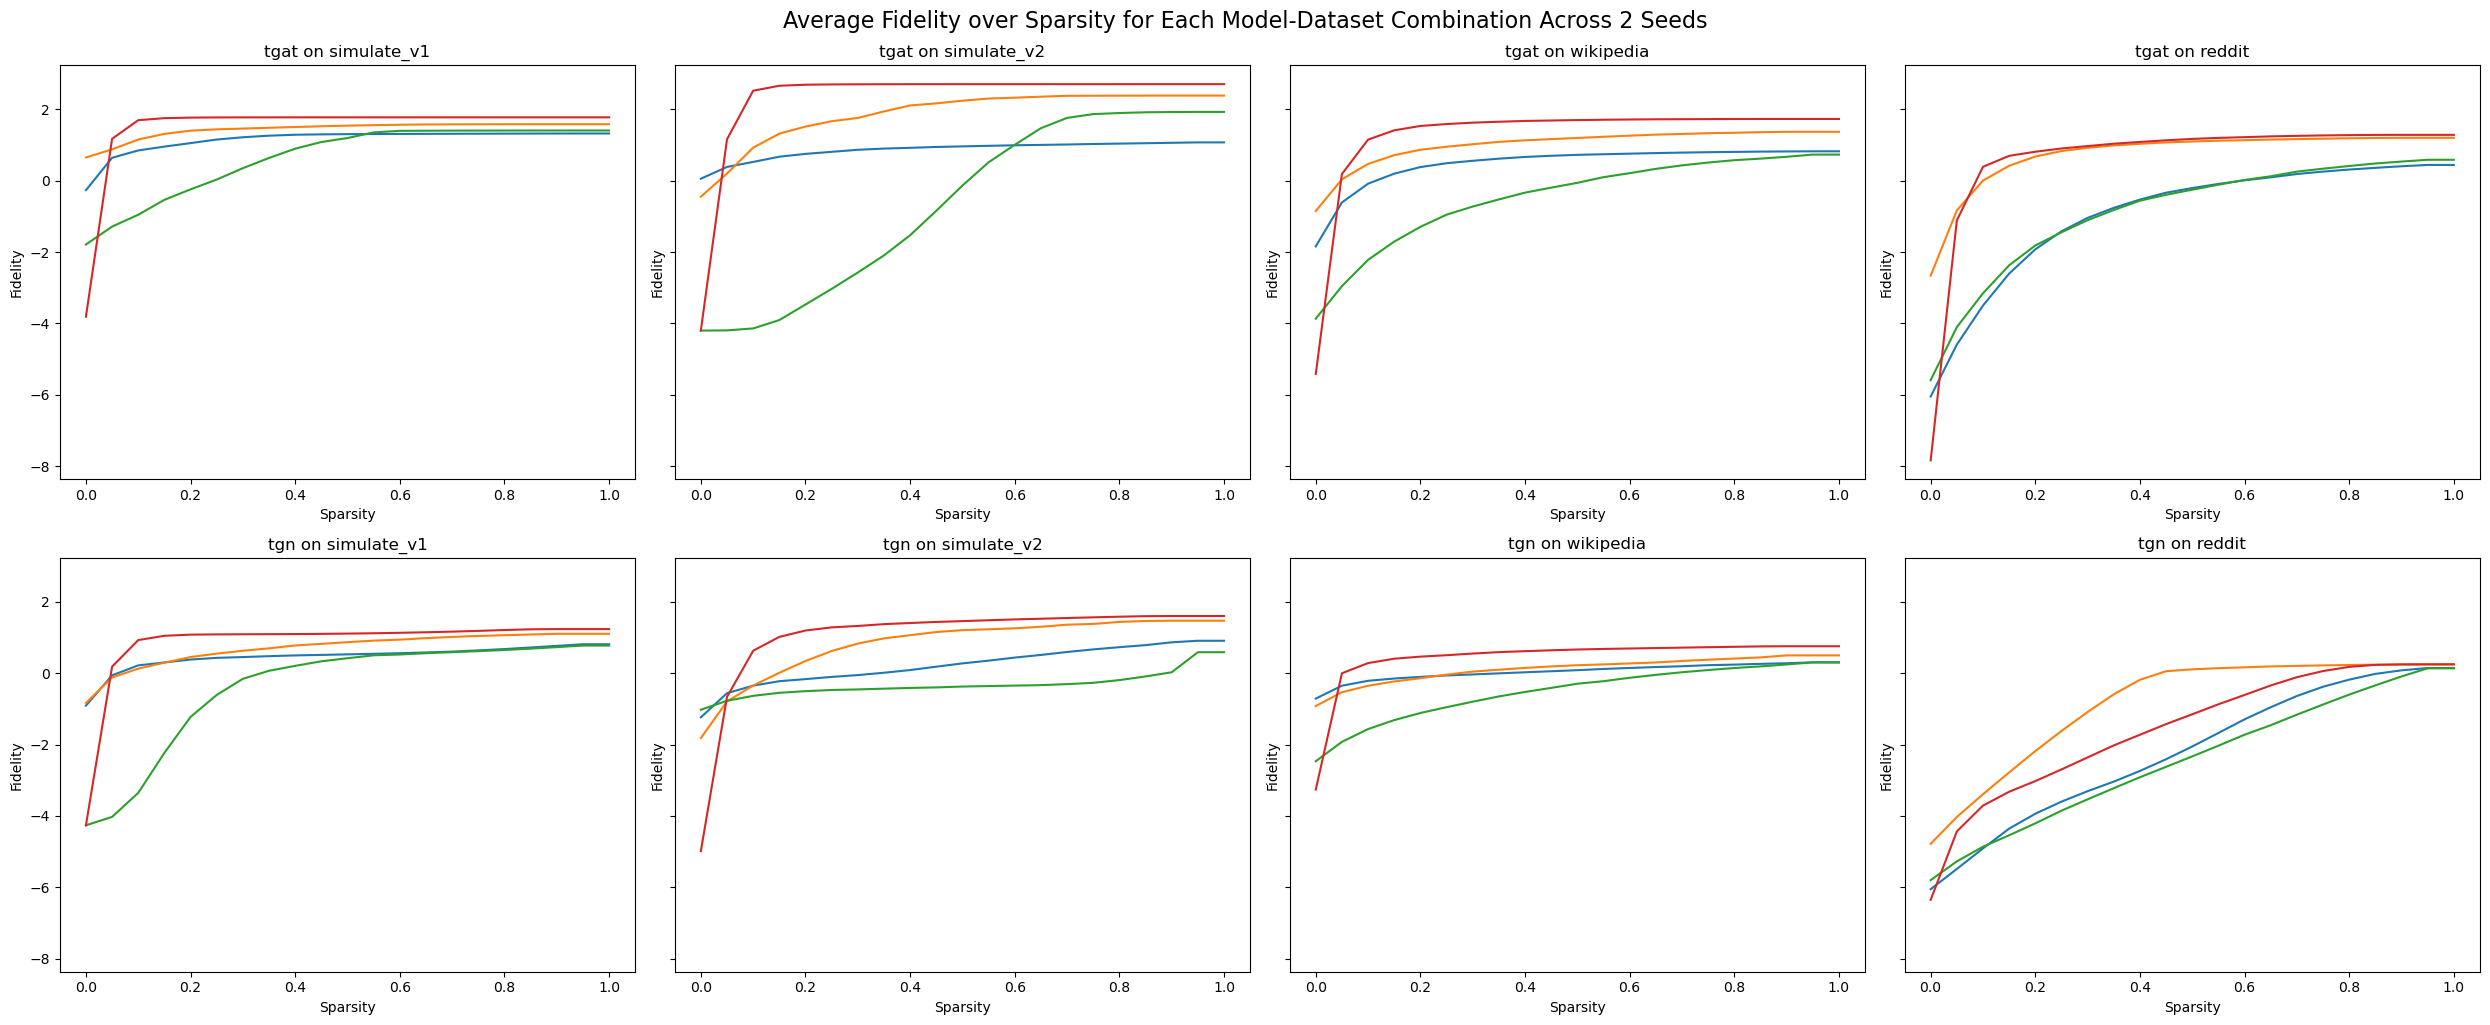

In [32]:

# Define the parts of the file names that change for the required combinations
models = ['tgn', 'tgat']
datasets = ['simulate_v1', 'simulate_v2', 'wikipedia', 'reddit', 'mooc']
explainers = ['attn_explainer', 'pbone_explainer', 'pg_explainer', 'subgraphx']
seeds = ['2', '2020']
output_folder = 'output_data'

# Create the output folder if it does not exist
if not os.path.exists(output_folder):
    os.makedirs(output_folder)
datasets_nomooc = ['simulate_v1', 'simulate_v2', 'wikipedia', 'reddit']
models = sorted(models, key=lambda x: x.lower() != 'tgat')

# Plotting setup, one plot per model-dataset combination
fig, axs = plt.subplots(len(models), len(datasets_nomooc), figsize=(5 * len(datasets), 5 * len(models)), sharey=True)
axs = np.array(axs).reshape(len(models), -1)  # Ensure axs is always 2-D

# DataFrame to store mean best fid for each combination
mean_best_fid_table = pd.DataFrame(columns=['Model', 'Dataset', 'Explainer', 'MeanBestFid', 'AUFSC', 'Seeds'])

# Store fidelity values for average plotting and track missing data
fidelity_values_by_explainer = {explainer: {f'{model}_{dataset}': pd.DataFrame() for dataset in datasets for model in models} 
                                for explainer in explainers}
missing_data = []

# Loop through all combinations
for model in models:
    for dataset in datasets:
        for explainer in explainers:
            explainer_data = []
            missing_seeds = []
            seeds_present = []
            for seed in seeds:
                file_pattern = f"{model}_{dataset}_{explainer}_tg_{seed}_*_eval.csv" if explainer != 'subgraphx' \
                    else f"{model}_{dataset}_{explainer}_tg_{seed}_*eval*.csv"
                matching_files = glob.glob(file_pattern)
                if not matching_files:
                    missing_seeds.append(seed)
                    continue

                file_path = matching_files[0]
                if os.stat(file_path).st_size == 0:
                    missing_seeds.append(seed)
                    continue

                df = pd.read_csv(file_path)
                explainer_data.append(df[['sparsity', 'fid_inv_best']])
                seeds_present.append(seed)

            if explainer_data:
                combined_df = pd.concat(explainer_data)
                mean_fid_by_sparsity = combined_df.groupby('sparsity')['fid_inv_best'].mean().reset_index()
                fidelity_values_by_explainer[explainer][f'{model}_{dataset}'] = mean_fid_by_sparsity

                # Calculate AUFSC for combined data
                aufsc = integrate.trapz(mean_fid_by_sparsity['fid_inv_best'], mean_fid_by_sparsity['sparsity'])
                mean_best_fid = mean_fid_by_sparsity['fid_inv_best'].mean()

                # Store results in the DataFrame
                new_row = {
                    'Model': model,
                    'Dataset': dataset,
                    'Explainer': explainer,
                    'MeanBestFid': mean_best_fid,
                    'AUFSC': aufsc,
                    'Seeds': ', '.join(seeds_present)
                }
                mean_best_fid_table = pd.concat([mean_best_fid_table, pd.DataFrame([new_row])], ignore_index=True)

            if len(missing_seeds) == len(seeds):
                missing_data.append(f'{model}/{dataset}/{explainer}: All seeds missing')
            elif missing_seeds:
                missing_data.append(f'{model}/{dataset}/{explainer}: Missing seeds {missing_seeds}')

# Sort models so that 'TGAT' comes before 'TGN'

# Plotting aggregated data
for i, model in enumerate(models):
    for j, dataset in enumerate(datasets_nomooc):
        ax = axs[i, j]
        for explainer in explainers:
            key = f'{model}_{dataset}'
            if not fidelity_values_by_explainer[explainer][key].empty:
                ax.plot(fidelity_values_by_explainer[explainer][key]['sparsity'],
                        fidelity_values_by_explainer[explainer][key]['fid_inv_best'], label=explainer)

        ax.set_title(f'{model} on {dataset}')
        ax.set_xlabel('Sparsity')
        ax.set_ylabel('Fidelity')

# Adjust layout and save the figure
plt.tight_layout()
plt.suptitle('Average Fidelity over Sparsity for Each Model-Dataset Combination Across 2 Seeds', fontsize=16, y=1.02)
plt.savefig(os.path.join(output_folder, 'average_model_dataset_combinations.png'))
plt.show()

# Save the mean best fidelity table to a CSV file in the new output folder
mean_best_fid_table.to_csv(os.path.join(output_folder, 'mean_best_fidelity_table.csv'), index=False)

# Output the missing data report
if missing_data:
    for item in missing_data:
        print(item)

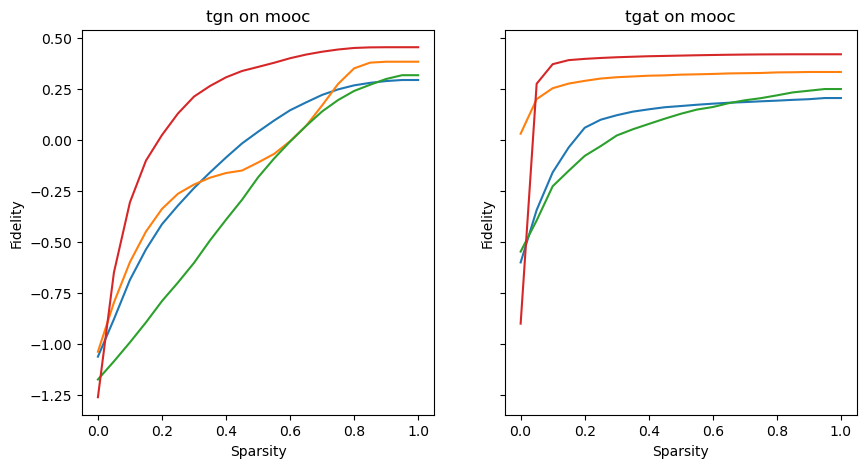

In [33]:
# Define the parts of the file names that change for the required combinations
models = ['tgn', 'tgat']
datasets = ['mooc']  # Only include 'mooc' in datasets
explainers = ['attn_explainer', 'pbone_explainer', 'pg_explainer', 'subgraphx']
seeds = ['2', '2020']
output_folder = 'output_data'

# Create the output folder if it does not exist
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

# Plotting setup, one plot per model-dataset combination
fig, axs = plt.subplots(1, len(models), figsize=(5 * len(models), 5), sharey=True)  # Change subplot layout to 1 row and len(models) columns

# Ensure axs is always 1-D
if len(models) == 1:
    axs = np.array([axs])
else:
    axs = np.array(axs).flatten()

# ... (rest of the code remains the same)

# Plotting aggregated data
for i, model in enumerate(models):
    ax = axs[i]  # Change indexing of axs to only use one index
    for explainer in explainers:
        key = f'{model}_mooc'  # Change key to always use 'mooc' as dataset
        if not fidelity_values_by_explainer[explainer][key].empty:
            ax.plot(fidelity_values_by_explainer[explainer][key]['sparsity'],
                    fidelity_values_by_explainer[explainer][key]['fid_inv_best'], label=explainer)

    ax.set_title(f'{model} on mooc')  # Change title to always use 'mooc' as dataset
    ax.set_xlabel('Sparsity')
    ax.set_ylabel('Fidelity')

to generate the latex table rows. First the old data was extracted. Then we can just run this code to generate the tables.

In [34]:
print(mean_best_fid_table)

   Model      Dataset        Explainer  MeanBestFid     AUFSC    Seeds
0   tgat  simulate_v1   attn_explainer     1.135949  1.166454  2, 2020
1   tgat  simulate_v1  pbone_explainer     1.431017  1.446892  2, 2020
2   tgat  simulate_v1     pg_explainer     0.634306  0.675668  2, 2020
3   tgat  simulate_v1        subgraphx     1.471823  1.596381  2, 2020
4   tgat  simulate_v2   attn_explainer     0.859088  0.873963  2, 2020
5   tgat  simulate_v2  pbone_explainer     1.856096  1.900671  2, 2020
6   tgat  simulate_v2     pg_explainer    -0.664200 -0.640520  2, 2020
7   tgat  simulate_v2        subgraphx     2.286323  2.438097  2, 2020
8   tgat    wikipedia   attn_explainer     0.461107  0.509704  2, 2020
9   tgat    wikipedia  pbone_explainer     0.998214  1.035280  2, 2020
10  tgat    wikipedia     pg_explainer    -0.474802 -0.420102  2, 2020
11  tgat    wikipedia        subgraphx     1.236202  1.390254  2, 2020
12  tgat       reddit   attn_explainer    -0.980050 -0.888888  2, 2020
13  tg

In [35]:
old_data = {
    'wikipedia': {
        'TGAT': {
            'Best Fid': {
                'attn_explainer': 0.891,
                'pbone_explainer': 0.027,
                'pg_explainer': 1.354,
                'subgraphx': 1.836
            },
            'AUFSC': {
                'attn_explainer': 0.564,
                'pbone_explainer': -2.227,
                'pg_explainer': 0.692,
                'subgraphx': 1.477
            }
        },
        'TGN': {
            'Best Fid': {
                'attn_explainer': 0.479,
                'pbone_explainer': 0.296,
                'pg_explainer': 0.464,
                'subgraphx': 0.866
            },
            'AUFSC': {
                'attn_explainer': 0.073,
                'pbone_explainer': -0.601,
                'pg_explainer': -0.231,
                'subgraphx': 0.590
            }
        }
    },
    'reddit': {
        'TGAT': {
            'Best Fid': {
                'attn_explainer': 0.658,
                'pbone_explainer': 0.167,
                'pg_explainer': 0.804,
                'subgraphx': 1.518
            },
            'AUFSC': {
                'attn_explainer': -0.654,
                'pbone_explainer': -2.492,
                'pg_explainer': -0.369,
                'subgraphx': 1.076
            }
        },
        'TGN': {
            'Best Fid': {
                'attn_explainer': 0.575,
                'pbone_explainer': 0.340,
                'pg_explainer': 0.679,
                'subgraphx': 1.362
            },
            'AUFSC': {
                'attn_explainer': 0.289,
                'pbone_explainer': -0.256,
                'pg_explainer': 0.020,
                'subgraphx': 1.113
            }
        }
    },
    'simulate_v1': {
        'TGAT': {
            'Best Fid': {
                'attn_explainer': 0.555,
                'pbone_explainer': 0.044,
                'pg_explainer': 0.476,
                'subgraphx': 0.780
            },
            'AUFSC': {
                'attn_explainer': 0.390,
                'pbone_explainer': -2.882,
                'pg_explainer': -0.081,
                'subgraphx': 0.666
            }
        },
        'TGN': {
            'Best Fid': {
                'attn_explainer': 2.178,
                'pbone_explainer': 0.000,
                'pg_explainer': 2.006,
                'subgraphx': 2.708
            },
            'AUFSC': {
                'attn_explainer': 1.624,
                'pbone_explainer': -3.311,
                'pg_explainer': 0.626,
                'subgraphx': 2.281
            }
        }
    },
    'simulate_v2': {
        'TGAT': {
            'Best Fid': {
                'attn_explainer': 0.605,
                'pbone_explainer': 0.096,
                'pg_explainer': 1.329,
                'subgraphx': 1.630
            },
            'AUFSC': {
                'attn_explainer': 0.291,
                'pbone_explainer': -4.771,
                'pg_explainer': -0.926,
                'subgraphx': 1.331
            }
        },
        'TGN': {
            'Best Fid': {
                'attn_explainer': 0.988,
                'pbone_explainer': 0.320,
                'pg_explainer': 1.012,
                'subgraphx': 4.356
            },
            'AUFSC': {
                'attn_explainer': -0.634,
                'pbone_explainer': -5.413,
                'pg_explainer': -1.338,
                'subgraphx': 3.224
            }
        }
    }
}


In [36]:
# Function to normalize values in a dictionary
def min_max_normalize(data_dict):
    min_val = min(data_dict.values())
    max_val = max(data_dict.values())
    if max_val == min_val:
        return {key: 0 for key in data_dict}
    return {key: (value - min_val) / (max_val - min_val) for key, value in data_dict.items()}

# Normalize data
normalized_data = {}
for dataset, models in old_data.items():
    normalized_data[dataset] = {}
    for model, metrics in models.items():
        normalized_data[dataset][model] = {}
        for metric, explainers in metrics.items():
            normalized_data[dataset][model][metric] = min_max_normalize(explainers)

# Print normalized data
for dataset, models in normalized_data.items():
    print(f"Dataset: {dataset}")
    for model, metrics in models.items():
        print(f"  Model: {model}")
        for metric, normalized_scores in metrics.items():
            print(f"    Metric: {metric}, Scores: {normalized_scores}")

# Calculate percentage differences
percentage_diffs = {}
for dataset, models in normalized_data.items():
    percentage_diffs[dataset] = {}
    for model, metrics in models.items():
        percentage_diffs[dataset][model] = {}
        for metric, scores in metrics.items():
            best_score = scores['subgraphx']
            scores_without_subgraphx = {k: v for k, v in scores.items() if k != 'subgraphx'}
            second_best_explainer = max(scores_without_subgraphx, key=scores_without_subgraphx.get)
            second_best_score = scores_without_subgraphx[second_best_explainer]
            if best_score != 0:
                percentage_difference = ((best_score - second_best_score) / best_score) * 100
            else:
                percentage_difference = None
            percentage_diffs[dataset][model][metric] = (second_best_explainer, percentage_difference)

# Print results
for dataset, models in percentage_diffs.items():
    print(f"Dataset: {dataset}")
    for model, metrics in models.items():
        for metric, result in metrics.items():
            explainer, percentage_diff = result
            print(f"  Model: {model}, Metric: {metric}, 2nd Best Explainer: {explainer}, % Difference: {percentage_diff}")

Dataset: wikipedia
  Model: TGAT
    Metric: Best Fid, Scores: {'attn_explainer': 0.4776119402985074, 'pbone_explainer': 0.0, 'pg_explainer': 0.7335544499723604, 'subgraphx': 1.0}
    Metric: AUFSC, Scores: {'attn_explainer': 0.7535097192224622, 'pbone_explainer': 0.0, 'pg_explainer': 0.7880669546436284, 'subgraphx': 1.0}
  Model: TGN
    Metric: Best Fid, Scores: {'attn_explainer': 0.3210526315789473, 'pbone_explainer': 0.0, 'pg_explainer': 0.2947368421052632, 'subgraphx': 1.0}
    Metric: AUFSC, Scores: {'attn_explainer': 0.5659109991603695, 'pbone_explainer': 0.0, 'pg_explainer': 0.3106633081444165, 'subgraphx': 1.0}
Dataset: reddit
  Model: TGAT
    Metric: Best Fid, Scores: {'attn_explainer': 0.3634344929681717, 'pbone_explainer': 0.0, 'pg_explainer': 0.47150259067357514, 'subgraphx': 1.0}
    Metric: AUFSC, Scores: {'attn_explainer': 0.5151345291479821, 'pbone_explainer': 0.0, 'pg_explainer': 0.5950112107623319, 'subgraphx': 1.0}
  Model: TGN
    Metric: Best Fid, Scores: {'attn_

In [37]:
# Function to print full DataFrame
def print_full(x):
    pd.set_option('display.max_rows', len(x))
    print(x)
    pd.reset_option('display.max_rows')

# Create DataFrame for old results
df_old = pd.DataFrame(columns=['Model', 'Dataset', 'Explainer', 'MeanBestFid', 'AUFSC', 'Seeds'])
seed = "2020"

# Populate DataFrame with old data
for dataset, models in old_data.items():
    for model, data in models.items():
        best_fid = data.get('Best Fid', {})
        aufsc = data.get('AUFSC', {})
        for explainer in best_fid:
            new_row = {'Model': model, 'Dataset': dataset, 'Explainer': explainer, 'MeanBestFid': best_fid[explainer], 'AUFSC': aufsc[explainer], 'Seeds': seed}
            df_old = pd.concat([df_old, pd.DataFrame([new_row])], ignore_index=True)

# Copy new data and label experiments
df_new = copy.deepcopy(mean_best_fid_table)
df_old['Experiment'] = 'Old'
df_new['Experiment'] = 'New'

# Combine old and new data
df_combined = pd.concat([df_old, df_new], ignore_index=True)

# Standardize text data
df_combined['Model'] = df_combined['Model'].str.lower()
df_combined['Dataset'] = df_combined['Dataset'].str.lower()
df_combined['Explainer'] = df_combined['Explainer'].str.lower()

# Filter for 'mooc' dataset
df_mooc = df_combined[df_combined['Dataset'].str.lower() == 'mooc'].copy()

# Print first few rows of 'mooc' DataFrame
print(df_mooc.head())

   Model Dataset        Explainer  MeanBestFid     AUFSC    Seeds Experiment
48  tgat    mooc   attn_explainer     0.077199  0.091028  2, 2020        New
49  tgat    mooc  pbone_explainer     0.293643  0.299335  2, 2020        New
50  tgat    mooc     pg_explainer     0.047418  0.057327  2, 2020        New
51  tgat    mooc        subgraphx     0.339436  0.368513  2, 2020        New
68   tgn    mooc   attn_explainer    -0.099025 -0.084676  2, 2020        New


C:\Users\jesse\AppData\Local\Temp\ipykernel_1416\1844146343.py:18: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_old = pd.concat([df_old, pd.DataFrame([new_row])], ignore_index=True)


In [41]:
# Split DataFrame into 'Old' and 'New'
df_old = df_combined[df_combined['Experiment'] == 'Old'].copy()
df_new = df_combined[df_combined['Experiment'] == 'New'].copy()

# Rename columns for merge
df_old.rename(columns={'MeanBestFid': 'Old_MeanBestFid', 'AUFSC': 'Old_AUFSC'}, inplace=True)
df_new.rename(columns={'MeanBestFid': 'New_MeanBestFid', 'AUFSC': 'New_AUFSC'}, inplace=True)

# Drop unnecessary columns
df_old.drop(['Seeds', 'Experiment'], axis=1, inplace=True)
df_new.drop(['Seeds', 'Experiment'], axis=1, inplace=True)

# Merge DataFrames on common keys
df_merged = pd.merge(df_old, df_new, on=['Model', 'Dataset', 'Explainer'], how='inner')

# Calculate deltas and add as new columns
df_merged['Delta_MeanBestFid'] = df_merged['New_MeanBestFid'] - df_merged['Old_MeanBestFid']
df_merged['Delta_AUFSC'] = df_merged['New_AUFSC'] - df_merged['Old_AUFSC']

# Print DataFrame with new delta columns
print(df_merged.head(100))

   Model      Dataset        Explainer  Old_MeanBestFid  Old_AUFSC  \
0   tgat    wikipedia   attn_explainer            0.891      0.564   
1   tgat    wikipedia  pbone_explainer            0.027     -2.227   
2   tgat    wikipedia     pg_explainer            1.354      0.692   
3   tgat    wikipedia        subgraphx            1.836      1.477   
4    tgn    wikipedia   attn_explainer            0.479      0.073   
5    tgn    wikipedia  pbone_explainer            0.296     -0.601   
6    tgn    wikipedia     pg_explainer            0.464     -0.231   
7    tgn    wikipedia        subgraphx            0.866      0.590   
8   tgat       reddit   attn_explainer            0.658     -0.654   
9   tgat       reddit  pbone_explainer            0.167     -2.492   
10  tgat       reddit     pg_explainer            0.804     -0.369   
11  tgat       reddit        subgraphx            1.518      1.076   
12   tgn       reddit   attn_explainer            0.575      0.289   
13   tgn       reddi

In [42]:
# Dictionary to hold each split DataFrame
dataset_dfs = {}

# Iterate over each unique dataset and create a separate DataFrame
for dataset in df_merged['Dataset'].unique():
    dataset_dfs[dataset.lower()] = df_merged[df_merged['Dataset'].str.lower() == dataset.lower()]

# Display the keys to confirm the split, which represent the dataset names
print(dataset_dfs.keys())

# Example: Access the DataFrame for a specific dataset, say 'mooc'
if 'mooc' in dataset_dfs:
    print(dataset_dfs['mooc'].head())


dict_keys(['wikipedia', 'reddit', 'simulate_v1', 'simulate_v2'])


In [43]:
def color_diff(value):
    if value == 'NR' or pd.isna(value):
        return "NR"
    try:
        value = float(value)
    except ValueError:
        return value
    
    # Neutral zone, black if similar
    if -0.10 <= value <= 0.10:
        return "{:.3f}".format(value)
    
    # Scaling factors (scale starts from 0.10)
    scaled_value = max(0, abs(value) - 0.10) / (1 - 0.10)  # Normalize scale to start from 0.10

    if value > 0:
        # Green if greater, scale intensity with magnitude
        color_code = f"\\textcolor{{green!{int(scaled_value * 100)}!black}}{{{value:.3f}}}"
    else:
        # Red if lower, scale intensity similarly
        color_code = f"\\textcolor{{red!{int(scaled_value * 100)}!black}}{{{value:.3f}}}"
    
    return color_code

def format_float(x):
    return f"{x:.3f}"

def bold_max_individual(df, column):
    """ Applies bold formatting to the maximum value in a specified column. """
    if column in df.columns:
        max_value = df[column].max()
        # Check if max_value is a number or a pre-formatted string
        if isinstance(max_value, str):
            df[column] = df[column].apply(lambda x: f"\\textbf{{{x}}}" if x == max_value else x)
        else:
            df[column] = df[column].apply(lambda x: f"\\textbf{{{x:.3f}}}" if x == max_value else f"{x:.3f}")
    else:
        print(f"Column {column} not found in DataFrame.")


column_mapping = {
    'Old_MeanBestFid': 'Old_BestFid',
    'New_MeanBestFid': 'New_BestFid',
    'Delta_MeanBestFid': 'Delta_BestFid',
    'Delta_AUFSC': 'Delta_AUFSC'
}

# First, ensure that your column renaming happens before any column-specific operations.
for key, df in dataset_dfs.items():
    df = df.rename(columns=column_mapping)
    dataset_dfs[key] = df  # Update the DataFrame in the dictionary

# Next, round and apply color formatting only to delta columns.
for key, df in dataset_dfs.items():
    numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns
    df[numeric_cols] = df[numeric_cols].round(3)

    if key != 'mooc':  # Apply coloring to delta columns
        df['Delta_BestFid'] = df['Delta_BestFid'].apply(color_diff)
        df['Delta_AUFSC'] = df['Delta_AUFSC'].apply(color_diff)
    dataset_dfs[key] = df

# Apply bold formatting, ensure to not affect delta columns
for key, df in dataset_dfs.items():
        for column in ['Old_BestFid', 'New_BestFid', 'Old_AUFSC', 'New_AUFSC']:
            bold_max_individual(df, column)
        dataset_dfs[key] = df  # Update the dictonary with the modified DataFrame

# Reorder columns lastly after all modifications
for key, df in dataset_dfs.items(): 
    if key != 'mooc':
        df = df[['Model', 'Explainer', 'Old_BestFid', 'New_BestFid', 'Delta_BestFid', 'Old_AUFSC', 'New_AUFSC', 'Delta_AUFSC']]
        dataset_dfs[key] = df

# Finally, generate LaTeX tables and save them
for key, df in dataset_dfs.items():
    file_path = f"{key}_dataframe.tex"
    latex_table = df.to_latex(index=False, escape=False, 
                              formatters={col: format_float for col in df.select_dtypes(include=['float', 'float64']).columns})
    with open(file_path, 'w') as file:
        file.write(latex_table)
    print(f"LaTeX table for {key} dataset saved to {file_path}")


LaTeX table for wikipedia dataset saved to wikipedia_dataframe.tex
LaTeX table for reddit dataset saved to reddit_dataframe.tex
LaTeX table for simulate_v1 dataset saved to simulate_v1_dataframe.tex
LaTeX table for simulate_v2 dataset saved to simulate_v2_dataframe.tex


finally their original paper results calculations, this was only to check their comparisons, nothing underneath is relevant for the reproduction.

In [ ]:
best_fid_TGAT_old = [ 1.836, 1.518, 0.780, 1.630]
second_best_fid_TGAT_old = [1.354, 0.804, 0.555, 1.329]

best_AUFSC_TGAT_old = [1.477, 1.076, 0.666, 1.331]
second_best_AUFSC_TGAT_old = [0.692, -0.369, 0.390, 0.291]

best_fid_TGN_old = [0.866, 1.362, 2.708, 4.356]
second_best_fid_TGN_old = [0.479, 0.679, 2.178, 1.012]

best_AUFSC_TGN_old = [0.590, 1.113, 2.281, 3.224]
second_best_AUFSC_TGN_old = [0.073, 0.289, 1.624, -0.634]

In [ ]:
# Calculate the percentage difference for each dataset
percentage_difference_fid_TGAT_old = calculate_percentage_difference(best_fid_TGAT_old, second_best_fid_TGAT_old)
percentage_difference_AUFSC_TGAT_old = calculate_percentage_difference(best_AUFSC_TGAT_old, second_best_AUFSC_TGAT_old)
percentage_difference_fid_TGN_old = calculate_percentage_difference(best_fid_TGN_old, second_best_fid_TGN_old)
percentage_difference_AUFSC_TGN_old = calculate_percentage_difference(best_AUFSC_TGN_old, second_best_AUFSC_TGN_old)

print("Percentage difference for fid_TGAT_old:", percentage_difference_fid_TGAT_old)
print("Percentage difference for AUFSC_TGAT_old:", percentage_difference_AUFSC_TGAT_old)
print("Percentage difference for fid_TGN_old:", percentage_difference_fid_TGN_old)
print("Percentage difference for AUFSC_TGN_old:", percentage_difference_AUFSC_TGN_old)

average_percentage_difference_AUFSC_old = np.mean(percentage_difference_AUFSC_TGAT_old + percentage_difference_AUFSC_TGN_old)
average_percentage_difference_fid_old = np.mean(percentage_difference_fid_TGAT_old + percentage_difference_fid_TGN_old)

print("Average percentage difference for AUFSC_old:", average_percentage_difference_AUFSC_old)
print("Average percentage difference for fid_old:", average_percentage_difference_fid_old)

print("average total", np.mean([average_percentage_difference_AUFSC_old, average_percentage_difference_fid_old]))

Percentage difference for fid_TGAT_old: [35.59822747415066, 88.80597014925372, 40.54054054054053, 22.648607975921742]
Percentage difference for AUFSC_TGAT_old: [113.43930635838153, -391.59891598915993, 70.76923076923077, 357.3883161512028]
Percentage difference for fid_TGN_old: [80.79331941544886, 100.58910162002945, 24.334251606978892, 330.4347826086956]
Percentage difference for AUFSC_TGN_old: [708.2191780821918, 285.12110726643607, 40.45566502463054, -608.5173501577287]
Average percentage difference for AUFSC_old: 71.9095671881481
Average percentage difference for fid_old: 90.46810017387743
average total 81.18883368101277


regards to reddit dataset bugs? Brief investigation that shows impossibilities in the data structure as how it is told to be structured (connections going both ways while it's supposed to be just a bipartite graph)

In [ ]:

with open('reddit.csv', 'r') as f:
    lines = f.read().splitlines()

data = [line.split(',') for line in lines]
df = pd.DataFrame(data)
print(df.head())

FileNotFoundError: [Errno 2] No such file or directory: 'reddit.csv'

In [ ]:
# Assuming the first column is at index 0 and the second column is at index 1
print("Number of unique values in column 1:", df[0].nunique())
#print("Unique values in column 1:", df[0].unique())

print("Number of unique values in column 2:", df[1].nunique())
#print("Unique values in column 2:", df[1].unique())

# Convert columns to sets
set_column1 = set(df[0])
set_column2 = set(df[1])

# Find common elements
common_indices = set_column1.intersection(set_column2)

# Print count of common elements
print("Number of common indices:", len(common_indices))

Number of unique values in column 1: 10001
Number of unique values in column 2: 985
Number of common indices: 984


In [ ]:
datasets = ['ml_mooc', 'ml_simulate_V1', 'ml_simulate_V2', 'ml_wikipedia', 'reddit']
for dataset in datasets:
    with open(f'{dataset}.csv', 'r') as f:
        lines = f.read().splitlines()

    data = [line.split(',') for line in lines]
    df = pd.DataFrame(data)
    print(f"Dataset: {dataset}")
    print(f"Number of rows: {len(df)}")
    print("\n")

    

Dataset: ml_mooc
Number of rows: 411750


Dataset: ml_simulate_V1
Number of rows: 16039


Dataset: ml_simulate_V2
Number of rows: 21753


Dataset: ml_wikipedia
Number of rows: 157475


Dataset: reddit
Number of rows: 672448


for chance of same test sample between our experiment and original experiment


In [ ]:
test_set_N = len(df)/100*15
print(test_set_N)

def calculate_overlap():
    # Calculate the probability of overlap for a specific item
    prob_overlap = (500/test_set_N) * (500/test_set_N)

    # Calculate the expected overlap
    expected_overlap = prob_overlap * test_set_N

    return expected_overlap

# Calculate and print the expected overlap
print("Expected overlap:", calculate_overlap())

100867.2
Expected overlap: 2.478506392563688


generation of bar plots for the accuracy comparisons between TGAT and TGN:


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Datasets names
datasets = ['Reddit', 'Wikipedia', 'MOOC', 'Synthetic1', 'Synthetic2']

# Accuracies for each model on each dataset
AUFSC_tgat = [0.630, 1.300, 0.182, 0.988, 0.380]  
AUFSC_tgn = [-1.060, 0.589, 0.437, 1.743, 2.415]  

mean_tgat = np.mean(AUFSC_tgat)
mean_tgn = np.mean(AUFSC_tgn)

std_tgat = np.std(AUFSC_tgat)
std_tgn = np.std(AUFSC_tgn)



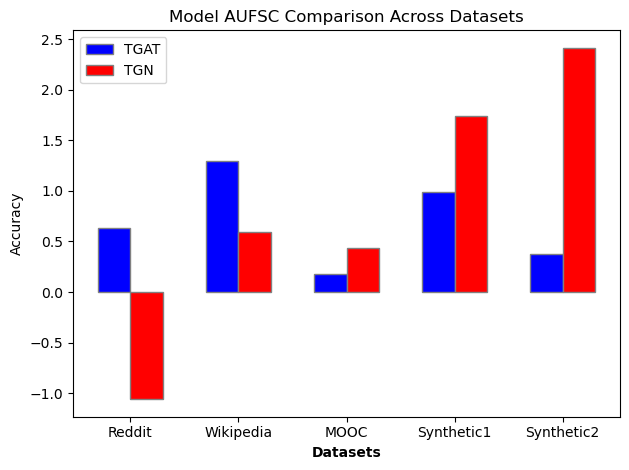

In [ ]:
# Set the breadth of a bar
barWidth = 0.3

# Set the position of the bars on the x-axis
r1 = np.arange(len(AUFSC_tgat))
r2 = [x + barWidth for x in r1]

# Create the bars
plt.bar(r1, AUFSC_tgat, color='blue', width=barWidth, edgecolor='grey', label='TGAT')
plt.bar(r2, AUFSC_tgn, color='red', width=barWidth, edgecolor='grey', label='TGN')

# Add xticks on the middle of the group bars
plt.xlabel('Datasets', fontweight='bold')
plt.xticks([r + barWidth/2 for r in range(len(AUFSC_tgat))], datasets)

# Create legend & title
plt.ylabel('Accuracy')
plt.title('Model AUFSC Comparison Across Datasets')
plt.legend()

# Display the chart
plt.tight_layout()
plt.show()


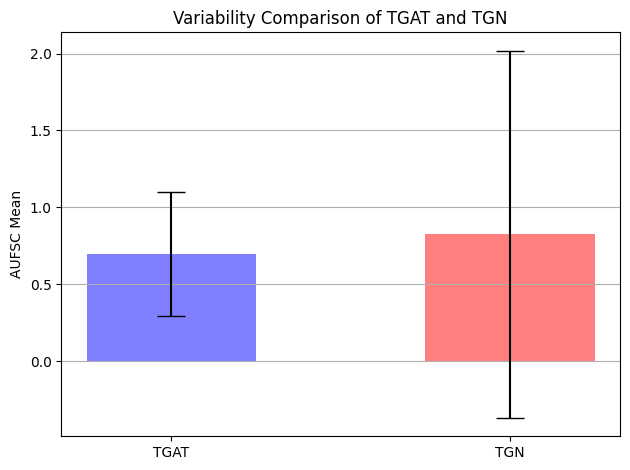

Plot saved successfully to output_data\Model_Variability_Comparison.pdf


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os

# Ensure the output directory exists
output_dir = "output_data"
os.makedirs(output_dir, exist_ok=True)

# Datasets names, assuming this list as given
datasets = ['Reddit', 'Wikipedia', 'MOOC', 'Synthetic1', 'Synthetic2']

# Actual AUFSC for each model on each dataset
AUFSC_tgat = [0.630, 1.300, 0.182, 0.988, 0.380]
AUFSC_tgn = [-1.060, 0.589, 0.437, 1.743, 2.415]

# Calculate means and standard deviations
mean_tgat = np.mean(AUFSC_tgat)
mean_tgn = np.mean(AUFSC_tgn)

std_tgat = np.std(AUFSC_tgat)
std_tgn = np.std(AUFSC_tgn)

# Set the positions and width for the bars
positions = [0, 1]
width = 0.5 

# Creating the plot
fig, ax = plt.subplots()
bars = plt.bar(positions, [mean_tgat, mean_tgn], yerr=[std_tgat, std_tgn], align='center', alpha=0.5, ecolor='black', capsize=10, width=width, color=['blue', 'red'])

# Customizing the plot
ax.set_ylabel('AUFSC Mean')
ax.set_title('Variability Comparison of TGAT and TGN')
ax.set_xticks(positions)
ax.set_xticklabels(['TGAT', 'TGN'])
ax.yaxis.grid(True)

# Save the figure in vector format for high-quality printing
plt.tight_layout()
save_path = os.path.join(output_dir, "Model_Variability_Comparison.pdf")
plt.savefig(save_path, format='pdf')

# Show the plot
plt.show()

print(f"Plot saved successfully to {save_path}")


T test for equal distributions of variation for original and new



In [ ]:
for key, df in dataset_dfs.items():
    # Display the first few rows of each DataFrame
    print(f"Dataset: {key}")
    print(df.head())

Dataset: wikipedia
  Model        Explainer     Old_BestFid     New_BestFid  \
0  tgat   attn_explainer           0.891           0.461   
1  tgat  pbone_explainer           0.027           0.998   
2  tgat     pg_explainer           1.354          -0.475   
3  tgat        subgraphx  \textbf{1.836}  \textbf{1.236}   
4   tgn   attn_explainer           0.479           0.034   

                       Delta_BestFid       Old_AUFSC       New_AUFSC  \
0   \textcolor{red!36!black}{-0.430}           0.564           0.510   
1  \textcolor{green!96!black}{0.971}          -2.227           1.035   
2  \textcolor{red!192!black}{-1.829}           0.692          -0.420   
3   \textcolor{red!55!black}{-0.600}  \textbf{1.477}  \textbf{1.390}   
4   \textcolor{red!38!black}{-0.445}           0.073           0.047   

                          Delta_AUFSC  
0                              -0.054  
1  \textcolor{green!351!black}{3.262}  
2   \textcolor{red!112!black}{-1.112}  
3                          

In [ ]:
n1 = 500 # the number of the first 500 experiments
n2 = 500 # the number of the second 500 experiments
from statsmodels.stats.weightstats import DescrStatsW, CompareMeans

#for mean1, mean2 in zip(0.590, 0.496):
mean1 = 0.590
mean2 = 0.496
d1 = DescrStatsW(data=[mean1]*n1)
d2 = DescrStatsW(data=[mean2]*n2)
cm = CompareMeans(d1, d2)
zstat, pval = cm.ztest_ind(usevar='unequal')
print(f"Z-statistic: {zstat}, p-value: {pval}")


Z-statistic: 3497075119898370.5, p-value: 0.0
